<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory analysis of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using [Folium](https://pypi.org/project/folium/) and [Geopy](https://geopy.readthedocs.io/en/stable/)

---


In [2]:
%%capture
!pip install geopandas
!pip install geopy
!pip install folium
!pip install gdown
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from tqdm.notebook import tqdm
from folium import Choropleth, Circle, CircleMarker, Marker
from folium.plugins import MarkerCluster
from collections import Counter
import nltk; nltk.download('stopwords')
import matplotlib.pyplot as plt

## Data loading

In [3]:
import os

if not os.path.exists('proverbs.csv'):
    proverbs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/proverbs.csv", index_col=0)
    proverbs.to_csv('proverbs.csv', index=False)
else:
    proverbs = pd.read_csv('proverbs.csv')

proverbs.shape

(134493, 4)

In [4]:
proverbs.sample(3)

,text,place,uri,collector
134069,Αλί στονε που γέρασε με του ντουνιά την έννοια,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/198565,anonymous
92633,Μπήκε ο λύκος στην κοπή αλλοιά που 'χε το ένα,"Ιωάννινα, Χουλιαράδες",http://hdl.handle.net/20.500.11853/277951,"Οικονομίδης, Δημήτριος Β."
5529,Στην αναβρεξιά καλό 'ν' και το χαλάζι,Κεφαλληνία,http://hdl.handle.net/20.500.11853/205139,"Βεργωτής, Π."


In [5]:
# removing noisy input (e.g., definitions)
proverbs[proverbs.text.str.contains("=")].sample().text.item()

"Είπ' ο γάδαρος το βούδι χειλά = La pelle moque du fourgon"

In [6]:
proverbs = proverbs[~proverbs.text.str.contains("=")]
proverbs.shape

(134106, 4)

* Duplicates exist
* Exact duplicates may be due to error
* But there are also duplicated texts, meaning proverbs collected in different places

In [11]:
# exact duplicates
print(proverbs.duplicated().sum())
proverbs[proverbs.duplicated()].sample()

13875


,text,place,uri,collector
131250,"Αν είχε μαμμή, εγλύτωνε το παιδί",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/215179,anonymous


In [14]:
# text duplicates
print(proverbs.text.duplicated().sum())
proverbs[proverbs.text.duplicated()].sample()

24836


,text,place,uri,collector
108498,Από Μάρτη καλοκαίρι κι' από Αύγουστο χειμώνα,Κέα,http://hdl.handle.net/20.500.11853/278836,"Σπυριδάκης, Γεώργιος Κ."


* Climbing up to the highest-level information per location labelled.

* In 'Κέρκυρα, Οθωνοί', for example, we only keep the first part of the term, using `split` to tokenise.

In [15]:
proverbs["area"] = proverbs.place.map(lambda x: x.split(",")[0])
proverbs.sample(3)

,text,place,uri,collector,area
113426,Η ομορφιά στον άντρωπο έναι μισό βασίλειο,"Μεσσηνία, Μανιάκι",http://hdl.handle.net/20.500.11853/201972,"Τσάκωνα, Μαγδαληνή Κ.",Μεσσηνία
128395,Ανεβαίνει σ' σα καλάτεα και σουλώνει παξιμάτεα,"Πόντος, Οινόη",http://hdl.handle.net/20.500.11853/215223,anonymous,Πόντος
124675,Άλλα τα λεγόμενα κι' άλλα τα βλεπόμενα,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/241323,anonymous,Άδηλου τόπου


* One more observation regards proverbs with no information about their location 


In [16]:
len(proverbs[proverbs.area=='Άδηλου τόπου'].text.unique())

3698

In [17]:
locations = proverbs.area.unique()
len(locations)

134

* There are 134 unique broad areas registered in the collection. We will find the geographical coordinates of each one.

* Using [geopy](https://geopy.readthedocs.io/en/stable/#), which is a Python client for geocoding web services, locating the coordinates (e.g., of addresses, cities, countries) across the globe.

* This is already done and saved, but you can repeat this step by geocoding each location in the dataframe with the following code. Adding the country's name in the query improves the accuracy, but geolocation still doesn't work for all places. Hence, some are printed and fixed by hand.  

In [ ]:
#@title [optional] Geocoding

if not os.path.exists('geolocs.csv'):
    from geopy.geocoders import Nominatim # import the library
    geolocator = Nominatim(user_agent="paremia") # initialise it

    geolocs = {}
    for loc in locations:
        # Avoiding polysemy by including "Greece" in the query
        location = geolocator.geocode(loc+ ", Ελλάδα") 
        if location:
            geolocs[loc] = {"lat":location.latitude, "lon":location.longitude}
        else:
            print (loc)

    # fixing some by hand (Cyprus was mislocated too)
    location = geolocator.geocode("Cyprus")
    geolocs["Κύπρος"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Siteia")
    geolocs["Ανατολική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Chania")
    geolocs["Δυτική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Nafpaktia")
    geolocs["Ναυπακτία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Lepenou")
    geolocs["Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Cappadocia")
    geolocs["Καππαδοκία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Imathia")
    geolocs["Ημαθία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Boeotia")
    geolocs["Βοιωτία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Edirne")
    geolocs["Ανατολική Θράκη"] = {"lat":location.latitude, "lon":location.longitude}
    geolocs["Αδριανούπολη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Phthiotis")
    geolocs["Φθιώτιδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Andritsaina")
    geolocs["Ανδρίτσαινα Ολυμπίου"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Dardanelles Strait")
    geolocs["Δαρδανέλλια (Ελλήσποντος)"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Central Greece")
    geolocs["Στερεά Ελλάδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Areopoli")
    geolocs["Αερόπολη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Trifylia")
    geolocs["Τριφυλία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Phocis")
    geolocs["Φωκίδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("West Mani")
    geolocs["Δυτική Μάνη"] = {"lat":location.latitude, "lon":location.longitude}

    pd.DataFrame(geolocs).to_csv("geolocs.csv", index=False)

In [18]:
geolocs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/geolocs.csv") 
geolocs.index=["lat", "lon"]
geolocs

,Κρήτη,Σίφνος,Σέρρες,Πήλιο,Ήπειρος,Λευκάδα,Αχαΐα,Εύβοια,Μακεδονία,Κύπρος,...,Ανατολική Θράκη,Αδριανούπολη,Φθιώτιδα,Ανδρίτσαινα Ολυμπίου,Δαρδανέλλια (Ελλήσποντος),Στερεά Ελλάδα,Αερόπολη,Τριφυλία,Φωκίδα,Δυτική Μάνη
lat,35.308495,36.971401,41.091071,39.365088,37.998253,38.706573,38.069275,38.494172,40.686024,34.982302,...,41.675933,41.675933,38.88734,37.483836,40.337606,38.562460,36.665918,37.195013,38.499868,22.581762
lon,24.463342,24.708110,23.549803,23.135561,23.737867,20.641709,21.872730,23.911084,23.693434,33.145128,...,26.558722,26.558722,22.36803,21.905533,26.640821,23.161853,22.381635,21.703732,22.248780,88.399181


* Now, updating the corpus with the mined information

In [19]:
geolocs = geolocs.to_dict()
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs[proverbs.lon.notna()].shape

(125222, 7)

## The anonymous collector
* Not all proverbs were collected by named individuals.

In [20]:
anonymous = proverbs[proverbs.collector=="anonymous"]
named = proverbs[proverbs.collector!="anonymous"]
print(f'{anonymous.shape[0]} proverbs from the anonymous collectors')

14835 proverbs from the anonymous collectors


## Duplicates

* Focusing on proverbs shared among locations.

* Using ones by named collectors.

* While the areas of the duplicates collected by anonymous individuals are not many.

In [21]:
num_named_duplicates = named.text.duplicated().sum()
num_anonymous_duplicates = anonymous.text.duplicated().sum()
num_sum_duplicates = num_named_duplicates + num_anonymous_duplicates
num_total_duplicates = proverbs.text.duplicated().sum()
print(f'Only {num_named_duplicates} duplicate proverbs from named collectors')
print(f'while {num_anonymous_duplicates} are from the anonymous collector')
print(f'Sum is {num_sum_duplicates} out of {num_total_duplicates} total duplicates')
print(f'Diff is {num_total_duplicates - num_sum_duplicates}')

Only 10861 duplicate proverbs from named collectors
while 13868 are from the anonymous collector
Sum is 24729 out of 24836 total duplicates
Diff is 107


* The difference above between the total duplicates and the sum of the named and the anonymous duplicates is explained by the existence of duplicates between named and anonymous.

In [22]:
pd.merge(named, anonymous, how='inner', on='text').text.unique().shape

(107,)

* The duplicates from the named collectors concern 104 locations.

In [23]:
named[named.text.duplicated()].area.unique()

array(['Εύβοια', 'Λέσβος', 'Ήπειρος', 'Ρούμελη', 'Κοζάνη', 'Αρκαδία',
       'Ίμβρος', 'Φιλιππούπολη', 'Αττική', 'Πόντος',
       'Δαρδανέλλια (Ελλήσποντος)', 'Θράκη', 'Μακεδονία', 'Κεφαλληνία',
       'Μήλος', 'Χίος', 'Μικρά Ασία', 'Κρήτη', 'Κίμωλος', 'Άνδρος',
       'Λέρος', 'Ρόδος', 'Κύπρος', 'Άρτα', 'Πρέβεζα', 'Παξοί', 'Καρδίτσα',
       'Άδηλου τόπου', 'Καστελλόριζο (Μεγίστη)', 'Αθήνα', 'Μεσσηνία',
       'Λακωνία', 'Σίφνος', 'Ηλεία', 'Σύμη', 'Θήρα (Σαντορίνη)', 'Κως',
       'Σμύρνη', 'Κάλυμνος', 'Νάξος', 'Αδριανούπολη', 'Ευρυτανία',
       'Κέρκυρα', 'Αμοργός', 'Θεσπρωτία', 'Σάμος', 'Καστοριά', 'Βοιωτία',
       'Επτάνησος', 'Νίσυρος', 'Αχαΐα', 'Κορινθία', 'Τήλος', 'Πέλλα',
       'Λάρισα', 'Κύθηρα', 'Ιωάννινα', 'Ημαθία', 'Φωκίδα', 'Πελοπόννησος',
       'Σύρος', 'Μάνη', 'Σκύρος', 'Αιτωλία', 'Κύθνος', 'Τήνος', 'Κέα',
       'Άγιον Όρος', 'Πάρος', 'Θεσσαλία', 'Μάλγαρα', 'Ανατολική Κρήτη',
       'Μαγνησία', 'Σέριφος', 'Ιθάκη', 'Λευκάδα', 'Αργολίδα',
       'Καππαδοκία', 'Ακαρναν

* We group by text the `named` duplicates , to get duplicates using items by named collectors.

In [24]:
grouping = named[named.lat.notna() & named.lon.notna()].groupby("text")
duplicates = pd.DataFrame({"place": grouping.place.apply(set)})
duplicates["place_num"] = duplicates.place.apply(len)
duplicates.sort_values(by="place_num", ascending=False)[:3]

,place,place_num
text,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Μικρά Ασία, Βιθυνία, Σιγή, Ήπειρος, Δρόβιανη,...",45
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Ήπειρος, Δρόβιανη, Θράκη, Αυδήμιο, Αργολίδα, ...",28
Θεωρία επισκόπου και καρδιά μυλωνά,"{Μακεδονία, Σισάνι, Λιμπόχοβο, Κρήτη, Κύπρος, ...",27


* Finding the broader location, which we'll call `area`.

In [25]:
duplicates["area"] = duplicates.place.map(lambda x: {i.split(",")[0] for i in x})
duplicates["area_num"] = duplicates.area.apply(len)
duplicates.sort_values(by="area_num", ascending=False)[:3]

,place,place_num,area,area_num
text,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Μικρά Ασία, Βιθυνία, Σιγή, Ήπειρος, Δρόβιανη,...",45,"{Ικαρία, Κρήτη, Αργολίδα, Αρκαδία, Κύπρος, Ανα...",23
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Νίσυρος, Νικειά, Ικαρία, Κοζάνη, Κοντοβούνι, ...",26,"{Ικαρία, Κρήτη, Αρκαδία, Ανατολική Θράκη, Φωκί...",20
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Ήπειρος, Δρόβιανη, Θράκη, Αυδήμιο, Αργολίδα, ...",28,"{Ήπειρος, Νάξος, Χίος, Θράκη, Κως, Μικρά Ασία,...",18


In [26]:
print(f"Out of the {duplicates.shape[0]} unique texts,", 
      f"{duplicates[duplicates.area_num>1].shape[0]} exist in multiple areas")

Out of the 105612 unique texts, 3204 exist in multiple areas


* We'll focus on proverbs common across `area`s.

In [27]:
duplicates = duplicates[duplicates.area_num>1]

* We add the geographical coordinates in the duplicates.

* We want a list per proverb, given that there is an 1:n mapping between proverbs and areas.

In [28]:
coordinates = duplicates.area.map(lambda x: [(geolocs[loc]["lat"], geolocs[loc]["lon"]) 
                                             for loc in x if loc in geolocs and loc!="Άδηλου τόπου"])
duplicates.insert(4, 'latlon', coordinates) 
duplicates.sample()

,place,place_num,area,area_num,latlon
text,,,,,
"Να σε κάψω Γιάννη, να σ'αλείψω λάδι","{Λακωνία, Μεσσηνία, Μανιάκι}",2,"{Μεσσηνία, Λακωνία}",2,"[(36.986899050000005, 21.82712495001949), (36...."


In [29]:
# saving
duplicates.to_pickle("duplicates_geolocated.csv")

* To visualise the dataframe, we use [Folium](https://python-visualization.github.io/folium), which is based on [leaflet](https://leafletjs.com/), an open-source JavaScript library for mobile-friendly interactive maps. 

* Note: outliers exist, e.g., Chiesa della Madona delle Neve

In [30]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=6)
for i in range(duplicates.shape[0]):
    loc = duplicates.iloc[i].latlon
    folium.PolyLine(loc, color='red', weight=1, opacity=0.1).add_to(m)
m.save("duplicates.html"); m

* Finding the number of areas sharing proverbs with crowdy Athens

In [31]:
area = 'Αθήνα'
print(f"Branching factor of {area}: {len(duplicates[duplicates.area.apply(lambda x: 'Αθήνα' in x)].area.explode().unique())}")

Branching factor of Αθήνα: 20


## Single-placed proverbs

In [32]:
# keeping single-placed proverbs
proverbs_sp = named[~named.text.duplicated(keep=False)]
print(proverbs_sp.shape[0])
proverbs_sp.sample(3)

100879


,text,place,uri,collector,area,lat,lon
78367,Μια φορά γίνεσαι νύφη,"Αργολίδα, Ερμιονίδα, Κρανίδι",http://hdl.handle.net/20.500.11853/288174,"Μερεμέτη, Δήμητρα",Αργολίδα,37.566266,22.855939
2951,Από κοπρέα λάχανα κι από σειρία γυναίκα,Μάνη,http://hdl.handle.net/20.500.11853/213154,"Βαγιακάκος, Δικαίος Β.",Μάνη,41.409747,26.402495
53140,Χαίρετ' ο νειος τη νειότη του κι' ο γέρος τη σ...,"Αχαΐα, Πάτρα",http://hdl.handle.net/20.500.11853/287095,"Κορύλλος, Χρήστος Π.",Αχαΐα,38.069275,21.872730


* We'll move aside single-placed proberbs from an unknown place.

In [33]:
unlocated = "Άδηλου τόπου"
proverbs_sp_unk = proverbs_sp[proverbs_sp.place==unlocated]
print(f'{proverbs_sp_unk.shape[0]} proverbs from one place, whose name is not known.')
proverbs_sp_unk.sample(3)

2755 proverbs from one place, whose name is not known.


,text,place,uri,collector,area,lat,lon
73987,Τσαγκάρης ξυπόλυτος και ράπτης ξεσχισμένος,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/265323,"Μανασσείδης, Συμεών Α.",Άδηλου τόπου,NaN,NaN
41476,"Όταν το σκυλί γαυγίζη, ρίξε του ένα κομμάτι ψωμί",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/247816,"Κασομούλης, Νικόλαος Κ.",Άδηλου τόπου,NaN,NaN
37337,Βρωμεί σαν τς εφτά σκύλους,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/191454,"Καλιτσουνάκης, Ι.",Άδηλου τόπου,NaN,NaN


* We'll work with the rest.

In [34]:
proverbs_sp = proverbs_sp[proverbs_sp.place!=unlocated]
print(f'{proverbs_sp.shape[0]} proverbs from one place with known place name')

98124 proverbs from one place with known place name


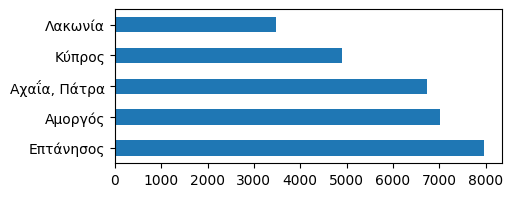

In [35]:
proverbs_sp.place.value_counts()[:5].plot.barh(figsize=(5,2));

* Visualising the places along with the number of proverbs collected in each.

In [36]:
freq_places = proverbs_sp.place.value_counts()[:20]
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for i in range(10):
    freq = freq_places.iloc[i]
    place = freq_places.index[i].split(",")[0]
    loc = geolocs[place]
    folium.CircleMarker((loc["lat"], loc["lon"]), 
                  radius=freq/500,
                  popup=f"{freq}",
                  color="#3186cc",
                  fill=True,
                  fill_color="#3186cc").add_to(m)
m.save('frequent_places.html'); m

* Next, we'll work with places which have 1,000 or more proverbs, allowing sampling without class imbalance issues.

In [37]:
group_level = "area"
placed = proverbs_sp.groupby(group_level)
placed_pd = pd.DataFrame({"text": placed.text.apply(list)})
placed_pd["length"] = placed_pd.text.apply(len)
print(f"Out of the {placed_pd.shape[0]} places, {placed_pd[placed_pd.length>1000].shape[0]} own 1000 proverbs or more.")

Out of the 129 places, 23 own 1000 proverbs or more.


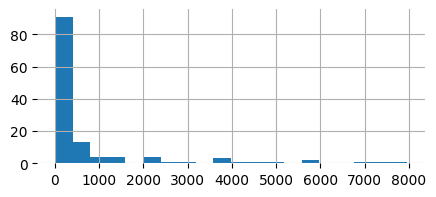

In [38]:
placed_pd.length.hist(bins=20, figsize=(5,2));
sns.despine(left=True, bottom=True)

* The proverbs from places reported at least 1,000 times are more than 80,000.

In [39]:
common_places = placed_pd[placed_pd.length>=1000].index
# filtering texts found on these places
common_sayings = proverbs_sp[proverbs_sp[group_level].isin(common_places)]
print(f"Found {common_sayings.shape[0]} proverbs from {len(common_places)} places")

Found 80893 proverbs from 23 places


* Removing proverbs with unknown (invalid?) characters.

In [40]:
stopchars = {'$', '*', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'N', 'O', 'P', 'S', 'T', 'W', '[', ']', 'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ä', '\ufeff'}
common_sayings_norm = common_sayings[~common_sayings.text.apply(lambda x: len(set(x).intersection(stopchars))>0)]

* Creating a location-balanced corpus.

In [41]:
balanced_corpus = pd.concat([common_sayings_norm[common_sayings_norm.area==a].sample(500) for a in common_places])
balanced_corpus.shape

(11500, 7)

## Location-based TFILF
* For each place, we compute character n-gram frequencies (TF).
* Terms infrequent across locations (location > document) are more important (ILF). 

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
long_texts = [" \n ".join(balanced_corpus[balanced_corpus.area==a].text.values) for a in common_places]
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, min_df=1, lowercase=True)
X = vect.fit_transform(long_texts)

In [45]:
# computing the TFIDF per place
geotfidf = pd.DataFrame(columns = common_places, index=vect.get_feature_names_out())
for i, a in enumerate(common_places):
    geotfidf[a] = np.array(X[i].sum(0))[0]

* Sorting the frequencies per place, gives characteristic n-grams; i.e., frequent locally yet infrequent globally.

In [46]:
geotfidf.sort_values(by="Κύπρος", ascending=False).head(3)

area,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
τζ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.018479,0.685606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
τζαι,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.445554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
τζαί,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.291915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* Computing a lexicon with the terms with the highest TFIDF value per area

In [48]:
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}
area_ngrams

{'Ήπειρος': ['ου', 'τουν', 'κάλλια'],
 'Αιτωλία': ['ου', 'είνι', 'μι'],
 'Αμοργός': ['μηδέ', 'κάλλιον', 'καλόν'],
 'Ανατολική Θράκη': ['πάγη', 'πάγει', 'πήγε'],
 'Αρκαδία': ['βλέπεις', 'έγινε', 'αγάλια'],
 'Αχαΐα': ['πέρνει', 'γκαμήλα', 'μόνον'],
 'Επτάνησος': ['ναν', 'θαν', 'οποίος'],
 'Εύβοια': ['τσαί', 'τσαι', 'μαύρη'],
 'Θεσπρωτία': ['κόλο', 'βρήκε', 'ατός'],
 'Θράκη': ['πε', 'πέ', 'ποδάρια'],
 'Ιωάννινα': ['ου', 'μι', 'τουν'],
 'Κάρπαθος': ['τσαι', 'εγιώ', 'μή'],
 'Κεφαλληνία': ['τση', 'τσου', 'εκειός'],
 'Κρήτη': ['καλλιά', 'ντου', 'τση'],
 'Κύπρος': ['τζ', 'τζαι', 'τζαί'],
 'Λέσβος': ['τσι', 'τουν', 'είνι'],
 'Λακωνία': ['βήτα', 'μίλια', 'γύρο'],
 'Μακεδονία': ['ου', 'τουν', 'μι'],
 'Μικρά Ασία': ['τουν', 'κη', 'είνιν'],
 'Νάξος': ['ια', 'τση', 'τζη'],
 'Πόντος': ['ατ', 'σο', 'ση'],
 'Ρόδος': ['κάμνει', 'είνε', 'γκαι'],
 'Σκύρος': ['τσαί', 'τσαι', 'έναι']}

* Locating the important terms per location on a map (clickable pins)

In [49]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for a in area_ngrams:
    ngrams = ", ".join(area_ngrams[a])
    loc = geolocs[a]
    folium.Circle([loc["lat"], loc["lon"]], 20000, fill=True).add_child(folium.Popup(ngrams)).add_to(m)
m.save('frequent_ngrams.html'); m

In [51]:
geotfidf.to_csv("geotfidf.csv")
pd.DataFrame(area_ngrams)

,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
0,ου,ου,μηδέ,πάγη,βλέπεις,πέρνει,ναν,τσαί,κόλο,πε,...,καλλιά,τζ,τσι,βήτα,ου,τουν,ια,ατ,κάμνει,τσαί
1,τουν,είνι,κάλλιον,πάγει,έγινε,γκαμήλα,θαν,τσαι,βρήκε,πέ,...,ντου,τζαι,τουν,μίλια,τουν,κη,τση,σο,είνε,τσαι
2,κάλλια,μι,καλόν,πήγε,αγάλια,μόνον,οποίος,μαύρη,ατός,ποδάρια,...,τση,τζαί,είνι,γύρο,μι,είνιν,τζη,ση,γκαι,έναι


In [52]:
# using English names and printing a latex table
loc_name = {'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Macedonia', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}
for area in area_ngrams:
    print(f'{loc_name[area]} & {" & ".join(area_ngrams[area])} \\\\')

Epirus & ου & τουν & κάλλια \\
Etolia & ου & είνι & μι \\
Amorgos & μηδέ & κάλλιον & καλόν \\
East Thrace & πάγη & πάγει & πήγε \\
Arcadia & βλέπεις & έγινε & αγάλια \\
Achaia & πέρνει & γκαμήλα & μόνον \\
Eptanisos & ναν & θαν & οποίος \\
Eyvoia & τσαί & τσαι & μαύρη \\
Thesprotia & κόλο & βρήκε & ατός \\
Thrace & πε & πέ & ποδάρια \\
Ioannina & ου & μι & τουν \\
Karpathos & τσαι & εγιώ & μή \\
Kefalinia & τση & τσου & εκειός \\
Crete & καλλιά & ντου & τση \\
Cyprus & τζ & τζαι & τζαί \\
Lesvos & τσι & τουν & είνι \\
Laconia & βήτα & μίλια & γύρο \\
Macedonia & ου & τουν & μι \\
Asia Minor & τουν & κη & είνιν \\
Naxos & ια & τση & τζη \\
Pontos & ατ & σο & ση \\
Rodos & κάμνει & είνε & γκαι \\
Skyros & τσαί & τσαι & έναι \\


In [54]:
balanced_corpus.to_csv('balanced_corpus.csv')